In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, utils, callbacks, metrics

import cv2
tf.__version__

c:\Users\Jeremy\Desktop\python\pp\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Jeremy\Desktop\python\pp\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\Users\Jeremy\Desktop\python\pp\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


'2.3.1'

In [2]:
df = pd.read_csv('train.csv')
num_classes=5

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.952899,0.952899,0.653986,0.438406,0.409420,0.403986,0.364130,0.309783,0.268116,0.222826,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.964968,0.646497,0.773885,0.366242,0.181529,0.162420,0.149682,0.146497,0.146497,0.136943,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,0.977551,1.000000,0.608163,0.393878,0.369388,0.324490,0.275510,0.226531,0.185714,0.144898,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.943878,0.905612,0.706633,0.239796,0.063776,0.150510,0.114796,0.043367,0.015306,0.043367,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.945338,0.848875,0.508039,0.234727,0.131833,0.125402,0.080386,0.086817,0.070740,0.073955,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df_train, df_val = train_test_split(df, test_size=0.2)

In [5]:
# last column: label
# other columns: ECG signals
x_train = df_train.iloc[:, :-1]
x_train = np.expand_dims(x_train, axis=-1)
y_train = df_train.iloc[:, -1]

x_val = df_val.iloc[:, :-1]
x_val = np.expand_dims(x_val, axis=-1)
y_val = df_val.iloc[:, -1]

y_train = utils.to_categorical(y_train, num_classes=num_classes)
y_val = utils.to_categorical(y_val, num_classes=num_classes)

In [6]:
# (# of data, signal length, channel)
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((1167, 187, 1), (1167, 5), (292, 187, 1), (292, 5))

label:  [1. 0. 0. 0. 0.]


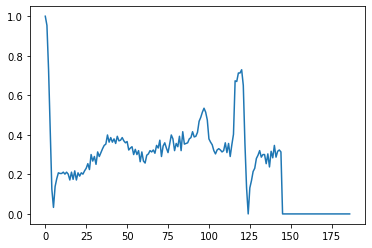

In [7]:
idx = np.random.randint(0, len(x_train))
print('label: ', y_train[idx])
plt.plot(x_train[idx])

In [8]:
np.unique(np.argmax(y_train, axis=-1), return_counts=True), np.unique(np.argmax(y_val, axis=-1), return_counts=True)

((array([0, 1, 2, 3, 4], dtype=int64),
  array([968,  36,  79,   8,  76], dtype=int64)),
 (array([0, 1, 2, 3, 4], dtype=int64),
  array([240,   9,  19,   2,  22], dtype=int64)))

In [9]:
y_train_weight =  np.unique(np.argmax(y_train, axis=-1), return_counts=True)

data_col = y_train_weight[0]
counts = y_train_weight[1]

print(data_col, counts)

weight = (1/counts) * np.sum(counts) / len(data_col)

class_weight = {i:w for i, w in enumerate(weight)}

print("class_weight:",class_weight)

[0 1 2 3 4] [968  36  79   8  76]
class_weight: {0: 0.24111570247933883, 1: 6.4833333333333325, 2: 2.9544303797468356, 3: 29.175, 4: 3.0710526315789473}


In [10]:
def build_model():
    inputs = layers.Input(shape=x_train.shape[1:])
    conv1_1 = layers.Conv1D(64, (6), activation='relu')(inputs)
    conv1_1 = layers.BatchNormalization()(conv1_1)
    pool1 = layers.Conv1D(64, 3, strides=(2), padding="same")(conv1_1)
    conv2_1 = layers.Conv1D(128, (3), activation='relu')(pool1)
    conv2_1 = layers.BatchNormalization()(conv2_1)
    pool2 = layers.Conv1D(128, 3, strides=(2), padding="same")(conv2_1)
    conv3_1 = layers.Conv1D(256, (3), activation='relu')(pool2)
    conv3_1 = layers.BatchNormalization()(conv3_1)
    pool3 = layers.Conv1D(256, 3, strides=(2), padding="same")(conv3_1)
    pool3 = layers.MaxPooling1D()(pool3)
    flatten = layers.GlobalAveragePooling1D()(pool3)
    dense_end1 = layers.Dense(64, activation='relu')(flatten)
    dense_end2 = layers.Dense(32, activation='relu')(dense_end1)
    main_output = layers.Dense(num_classes, activation='softmax', name='main_output')(dense_end2)
    
    model = models.Model(inputs, main_output)
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

In [11]:
model = build_model()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 187, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 182, 64)           448       
_________________________________________________________________
batch_normalization (BatchNo (None, 182, 64)           256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 91, 64)            12352     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 89, 128)           24704     
_________________________________________________________________
batch_normalization_1 (Batch (None, 89, 128)           512       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 45, 128)          

In [12]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
            tf.keras.callbacks.ModelCheckpoint(filepath='model.h5', monitor='val_loss', save_best_only=True),
            tf.keras.callbacks.ReduceLROnPlateau("val_loss", factor=0.2, patience=3, min_lr=0.001)
            ]

In [13]:
logs = model.fit(x_train, 
                    y_train, 
                    epochs=200,
                    callbacks=callback, 
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    #class_weight = class_weight   
                    )

Epoch 1/200
37/37 [==============================] - 1s 39ms/step - loss: 0.7082 - accuracy: 0.8089 - val_loss: 1.0000 - val_accuracy: 0.8219
Epoch 2/200
37/37 [==============================] - 1s 32ms/step - loss: 0.4701 - accuracy: 0.8552 - val_loss: 1.3500 - val_accuracy: 0.1781
Epoch 3/200
37/37 [==============================] - 1s 33ms/step - loss: 0.3390 - accuracy: 0.9049 - val_loss: 1.2802 - val_accuracy: 0.0753
Epoch 4/200
37/37 [==============================] - 1s 33ms/step - loss: 0.2878 - accuracy: 0.9152 - val_loss: 1.6465 - val_accuracy: 0.0753
Epoch 5/200
37/37 [==============================] - 1s 32ms/step - loss: 0.2500 - accuracy: 0.9357 - val_loss: 1.8955 - val_accuracy: 0.0856
Epoch 6/200
37/37 [==============================] - 1s 31ms/step - loss: 0.2242 - accuracy: 0.9349 - val_loss: 2.0168 - val_accuracy: 0.0753
Epoch 7/200
37/37 [==============================] - 1s 33ms/step - loss: 0.1923 - accuracy: 0.9426 - val_loss: 1.5103 - val_accuracy: 0.0788
Epoch 

Text(0.5, 1.0, 'Accuracy')

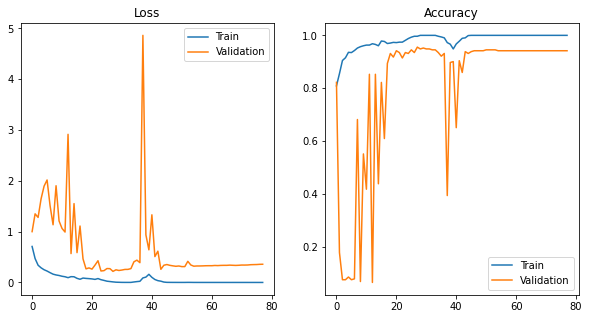

In [17]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(logs.history["loss"])
plt.plot(logs.history["val_loss"])
plt.legend(["Train","Validation"])
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(logs.history["accuracy"])
plt.plot(logs.history["val_accuracy"])
plt.legend(["Train","Validation"])
plt.title("Accuracy")

In [18]:
def cls_report(path):
    model = models.load_model(path)
    pred = np.argmax(model.predict(x_val), axis=-1)
    print(classification_report(np.argmax(y_val, axis=-1), pred))
    print(confusion_matrix(np.argmax(y_val, axis=-1), pred))

In [19]:
cls_report('model.h5')


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       240
           1       0.71      0.56      0.63         9
           2       0.86      0.95      0.90        19
           3       0.33      0.50      0.40         2
           4       1.00      0.86      0.93        22

    accuracy                           0.96       292
   macro avg       0.78      0.77      0.77       292
weighted avg       0.96      0.96      0.96       292

[[236   2   2   0   0]
 [  3   5   0   1   0]
 [  0   0  18   1   0]
 [  1   0   0   1   0]
 [  2   0   1   0  19]]
